In [1]:
import matplotlib.pyplot as plt
import numpy as np

from datasets.mnist import MNIST

from models.cae_model import CAE
from models.conv_model import CNN

from train import train_ae, train_cnn

from cem import ContrastiveExplanationMethod

In [2]:
dataset = MNIST()
# dataset = FashionMNIST()

# Training the classifier

In [3]:
cnn = CNN()

train_cnn(cnn, dataset, iterations=2, lr=0.001, device='cpu', save_fn='mnist-cnn', load_path="./models/saved_models/b_mnist-cnn.h5")

In [4]:
images, _ = dataset.get_batch()

output = cnn(images)

images = images.numpy()
output = output.detach().numpy()


D:\david\Coding\uva-fact-ai\models\conv_model.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = nn.functional.softmax(out)


# Training the autoencoder

This section trains the autoencoder which will be used as regularizer for the data space which the perturbations are found in.

In [5]:
# Train or load autoencoder
cae = CAE()

train_ae(cae, dataset, iterations=2, save_fn="mnist-cae", load_path="./models/saved_models/b-mnist-cae.h5")

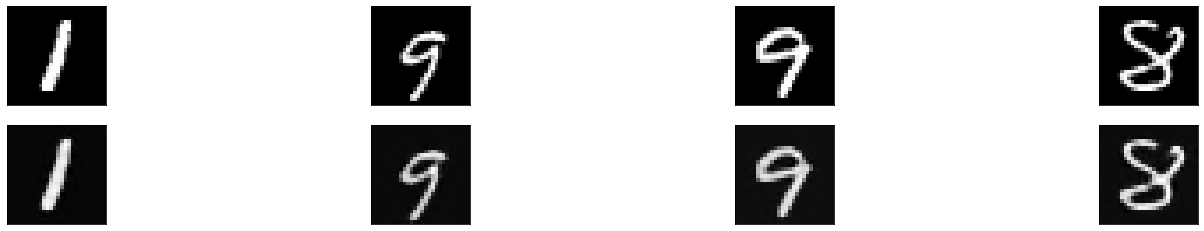

In [6]:
# obtain one batch of test images
images, _ = dataset.get_batch()

#images_flatten = images.view(images.size(0), -1)
# get sample outputs
output = cae(images)
# prep images for display
images = images.numpy()

# output is resized into a batch of images
# output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# Contrastive Explanation Method

In [7]:
CEM = ContrastiveExplanationMethod(cnn, cae, iterations=1000, n_searches=9, kappa=10, gamma=100)

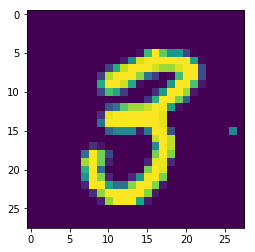

In [8]:
# obtain one sample
image, _ = dataset.get_sample()

plt.imshow(image.squeeze())

In [9]:
# find pertinent negatives
CEM.fista(image, mode="PN")

search: 0 - iteration: 0 - c value:10.00 - loss: 247.46 - delta sum: 0.00 - has reached optimum: False
NEW BEST: 2754.5771484375 - C: 10
search: 0 - iteration: 20 - c value:10.00 - loss: 19686.38 - delta sum: 311.58 - has reached optimum: True
search: 0 - iteration: 40 - c value:10.00 - loss: 21383.32 - delta sum: 308.69 - has reached optimum: True
search: 0 - iteration: 60 - c value:10.00 - loss: 21804.48 - delta sum: 308.44 - has reached optimum: True
search: 0 - iteration: 80 - c value:10.00 - loss: 21824.12 - delta sum: 307.84 - has reached optimum: True
search: 0 - iteration: 100 - c value:10.00 - loss: 22065.51 - delta sum: 307.78 - has reached optimum: True
search: 0 - iteration: 120 - c value:10.00 - loss: 22150.53 - delta sum: 307.33 - has reached optimum: True
search: 0 - iteration: 140 - c value:10.00 - loss: 22728.99 - delta sum: 310.37 - has reached optimum: True
search: 0 - iteration: 160 - c value:10.00 - loss: 22546.96 - delta sum: 311.27 - has reached optimum: True
sea

search: 1 - iteration: 500 - c value:5.05 - loss: 23436.71 - delta sum: 313.80 - has reached optimum: True
search: 1 - iteration: 520 - c value:5.05 - loss: 23343.33 - delta sum: 313.43 - has reached optimum: True
search: 1 - iteration: 540 - c value:5.05 - loss: 23560.40 - delta sum: 314.29 - has reached optimum: True
search: 1 - iteration: 560 - c value:5.05 - loss: 22868.43 - delta sum: 312.97 - has reached optimum: True
search: 1 - iteration: 580 - c value:5.05 - loss: 22961.47 - delta sum: 313.12 - has reached optimum: True
search: 1 - iteration: 600 - c value:5.05 - loss: 23088.14 - delta sum: 314.25 - has reached optimum: True
search: 1 - iteration: 620 - c value:5.05 - loss: 23069.25 - delta sum: 312.63 - has reached optimum: True
search: 1 - iteration: 640 - c value:5.05 - loss: 23170.76 - delta sum: 314.13 - has reached optimum: True
search: 1 - iteration: 660 - c value:5.05 - loss: 23140.99 - delta sum: 312.86 - has reached optimum: True
search: 1 - iteration: 680 - c value:

search: 3 - iteration: 20 - c value:1.34 - loss: 20049.65 - delta sum: 312.06 - has reached optimum: True
search: 3 - iteration: 40 - c value:1.34 - loss: 20609.30 - delta sum: 310.39 - has reached optimum: True
search: 3 - iteration: 60 - c value:1.34 - loss: 21322.30 - delta sum: 312.23 - has reached optimum: True
search: 3 - iteration: 80 - c value:1.34 - loss: 21637.21 - delta sum: 312.16 - has reached optimum: True
search: 3 - iteration: 100 - c value:1.34 - loss: 21786.17 - delta sum: 314.65 - has reached optimum: True
search: 3 - iteration: 120 - c value:1.34 - loss: 22428.24 - delta sum: 316.27 - has reached optimum: True
search: 3 - iteration: 140 - c value:1.34 - loss: 21980.26 - delta sum: 317.07 - has reached optimum: True
search: 3 - iteration: 160 - c value:1.34 - loss: 22044.41 - delta sum: 316.04 - has reached optimum: True
search: 3 - iteration: 180 - c value:1.34 - loss: 22050.90 - delta sum: 314.37 - has reached optimum: True
search: 3 - iteration: 200 - c value:1.34

search: 4 - iteration: 540 - c value:0.72 - loss: 22078.71 - delta sum: 311.30 - has reached optimum: False
search: 4 - iteration: 560 - c value:0.72 - loss: 22074.51 - delta sum: 311.20 - has reached optimum: False
search: 4 - iteration: 580 - c value:0.72 - loss: 22075.74 - delta sum: 311.22 - has reached optimum: False
search: 4 - iteration: 600 - c value:0.72 - loss: 22077.12 - delta sum: 311.25 - has reached optimum: False
search: 4 - iteration: 620 - c value:0.72 - loss: 22078.46 - delta sum: 311.27 - has reached optimum: False
search: 4 - iteration: 640 - c value:0.72 - loss: 22080.71 - delta sum: 311.40 - has reached optimum: False
search: 4 - iteration: 660 - c value:0.72 - loss: 22085.39 - delta sum: 311.37 - has reached optimum: False
search: 4 - iteration: 680 - c value:0.72 - loss: 22104.66 - delta sum: 311.56 - has reached optimum: False
search: 4 - iteration: 700 - c value:0.72 - loss: 22187.99 - delta sum: 310.72 - has reached optimum: False
search: 4 - iteration: 720 -

search: 6 - iteration: 60 - c value:3.64 - loss: 22116.35 - delta sum: 309.47 - has reached optimum: True
search: 6 - iteration: 80 - c value:3.64 - loss: 22424.67 - delta sum: 309.03 - has reached optimum: True
search: 6 - iteration: 100 - c value:3.64 - loss: 22563.17 - delta sum: 309.42 - has reached optimum: True
search: 6 - iteration: 120 - c value:3.64 - loss: 22741.10 - delta sum: 309.60 - has reached optimum: True
search: 6 - iteration: 140 - c value:3.64 - loss: 22907.23 - delta sum: 309.70 - has reached optimum: True
search: 6 - iteration: 160 - c value:3.64 - loss: 22864.32 - delta sum: 308.50 - has reached optimum: True
search: 6 - iteration: 180 - c value:3.64 - loss: 22692.62 - delta sum: 308.77 - has reached optimum: True
search: 6 - iteration: 200 - c value:3.64 - loss: 22716.64 - delta sum: 308.75 - has reached optimum: True
search: 6 - iteration: 220 - c value:3.64 - loss: 22792.33 - delta sum: 308.90 - has reached optimum: True
search: 6 - iteration: 240 - c value:3.

search: 7 - iteration: 580 - c value:1.87 - loss: 23225.80 - delta sum: 310.31 - has reached optimum: True
search: 7 - iteration: 600 - c value:1.87 - loss: 23263.43 - delta sum: 310.48 - has reached optimum: True
search: 7 - iteration: 620 - c value:1.87 - loss: 23208.48 - delta sum: 310.08 - has reached optimum: True
search: 7 - iteration: 640 - c value:1.87 - loss: 23298.34 - delta sum: 310.18 - has reached optimum: True
search: 7 - iteration: 660 - c value:1.87 - loss: 23224.72 - delta sum: 310.00 - has reached optimum: True
search: 7 - iteration: 680 - c value:1.87 - loss: 23416.07 - delta sum: 312.00 - has reached optimum: True
search: 7 - iteration: 700 - c value:1.87 - loss: 23127.47 - delta sum: 309.94 - has reached optimum: True
search: 7 - iteration: 720 - c value:1.87 - loss: 23280.34 - delta sum: 310.58 - has reached optimum: True
search: 7 - iteration: 740 - c value:1.87 - loss: 23286.20 - delta sum: 310.70 - has reached optimum: True
search: 7 - iteration: 760 - c value:

In [10]:
# import os
# os.environ["PATH"] += os.pathsep + 'D:/Program Files/Graphviz/bin'

# from torchviz import make_dot
# make_dot(CEM.loss).view()

In [11]:
print(CEM.best_delta - image.view(28*28))

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        5.9613e-02, 4.7866e-02, 3.1371e-02, 0.0000e+00, 0.0000e+00, 3.6179e-02,
        2.8884e-02, 1.0828e-01, 1.1487e-01, 5.5840e-02, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 5.9520e-02, 2.1343e-01, 6.0775e-02,
        7.7795e-02, 1.3449e-01, 7.0172e-02, 0.0000e+00, 0.0000e+00, 1.9096e-02,
        1.3520e-01, 2.1268e-02, 0.0000e+00, 2.4948e-01, 3.3255e-01, 8.0713e-02,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.7681e-01, 3.8272e-01, 2.2976e-01,
        3.6382e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 9.2268e-03, 3.4552e-01, 3.0113e-01, 2.9788e-01, 1.8753e-01,
        2.0720e-02, 0.0000e+00, 0.0000e+00, 4.4237e-02, 5.0000e-01, 1.3622e-01,
        5.7168e-02, 4.3797e-01, 3.1996e-01, 3.6091e-02, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 8.3532e-02, 6.5676e-02, 1.8814e-02, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+

        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00])


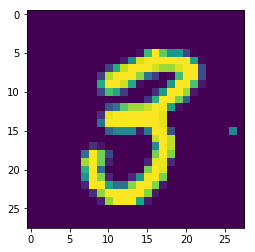

In [12]:
plt.imshow(image.squeeze())

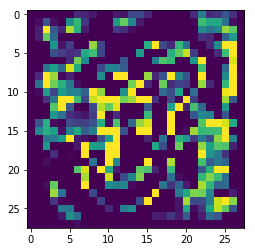

In [13]:
plt.imshow(CEM.best_delta.view(28,28) - image.squeeze())

In [14]:
# classification after
np.argmax(cnn(CEM.best_delta.view(1,28,28)).detach())

tensor(8)

In [15]:
# classification before
np.argmax(cnn(image.squeeze(-1)).detach())

tensor(3)

In [16]:
print(CEM.best_loss)

2284.42236328125


In [17]:
print(CEM.best_pert_loss)

tensor(0.)


In [18]:
print(CEM.best_c)

10
